### Analyses code

### Sanittawan Tan

In [62]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# import warnings
# warnings.filterwarnings('ignore')

### Data preparation

In [16]:
prelim_dtype = {'year': 'Int64', 'country': 'string', 'Status': 'string'}
dem = pd.read_csv('./democracy.csv')

In [17]:
dem[:15]

country  year  PR  CL Status  FH_category  FH_F  FH_NF  FH_PF  \
0   afghanistan  2008   5   6     NF            0     0      1      0   
1   afghanistan  2009   6   6     NF            0     0      1      0   
2   afghanistan  2010   6   6     NF            0     0      1      0   
3   afghanistan  2011   6   6     NF            0     0      1      0   
4   afghanistan  2012   6   6     NF            0     0      1      0   
5   afghanistan  2013   6   6     NF            0     0      1      0   
6   afghanistan  2014   6   6     NF            0     0      1      0   
7   afghanistan  2015   6   6     NF            0     0      1      0   
8   afghanistan  2016   6   6     NF            0     0      1      0   
9   afghanistan  2017   5   6     NF            0     0      1      0   
10      albania  2008   3   3     PF            1     0      0      1   
11      albania  2009   3   3     PF            1     0      0      1   
12      albania  2010   3   3     PF            1     0      0      1   
13      albania  2011   3   3     PF            1     0      0      1   
14      albania  2012   3   3     PF            1     0      0      1   

    BMR_democracy  ...  v2elpubfin_ord  v2elembaut_ord  v2elmulpar_ord  \
0             0.0  ...             0.0             2.0             NaN   
1             0.0  ...             0.0             2.0             3.0   
2             0.0  ...             0.0             2.0             3.0   
3             0.0  ...             0.0             2.0             NaN   
4             0.0  ...             0.0             2.0             NaN   
5             0.0  ...             0.0             1.0             NaN   
6             0.0  ...             0.0             1.0             2.0   
7             0.0  ...             0.0             1.0             NaN   
8             NaN  ...             0.0             1.0             NaN   
9             NaN  ...             0.0             1.0             NaN   
10            1.0  ...             3.0             2.0             NaN   
11            1.0  ...             3.0             2.0             4.0   
12            1.0  ...             3.0             2.0             NaN   
13            1.0  ...             3.0             2.0             NaN   
14            1.0  ...             3.0             2.0             NaN   

    v2elvotbuy_ord  v2elfrcamp_ord  v2elfrfair_ord  v2elaccept_ord  \
0              NaN             NaN             NaN             NaN   
1              0.0             2.0             2.0             3.0   
2              1.0             2.0             2.0             3.0   
3              NaN             NaN             NaN             NaN   
4              NaN             NaN             NaN             NaN   
5              NaN             NaN             NaN             NaN   
6              1.0             2.0             2.0             2.0   
7              NaN             NaN             NaN             NaN   
8              NaN             NaN             NaN             NaN   
9              NaN             NaN             NaN             NaN   
10             NaN             NaN             NaN             NaN   
11             1.0             2.0             3.0             3.0   
12             NaN             NaN             NaN             NaN   
13             NaN             NaN             NaN             NaN   
14             NaN             NaN             NaN             NaN   

    v2elasmoff_ord  v2elintim  is_erosion  
0              NaN        NaN           0  
1              2.0     -0.421           0  
2              2.0     -0.376           0  
3              NaN        NaN           0  
4              NaN        NaN           0  
5              NaN        NaN           0  
6              2.0     -0.353           0  
7              NaN        NaN           0  
8              NaN        NaN           0  
9              NaN        NaN           0  
10             NaN        NaN           1  
11   

In [18]:
# current shape
dem.shape

(1946, 76)

In [19]:
nominal = ['v2lgfunds_ord', 'v2lgamend',
            'v2exhoshog', 'v2exaphogp', 'v2exaphos', 'v2ddlexci',
            'v2ddlexrf', 'v2ddlexpl'
]

In [20]:
count = 0
for col in nominal:
    uniq_val = len(dem[col].unique())
    print(uniq_val)
    count += uniq_val

3
3
3
3
3
4
4
4


In [22]:
for col in nominal:
    pref = col + '_'
    cols_to_concat = pd.get_dummies(dem[col], prefix=pref, drop_first=True)
    dem = pd.concat([dem, cols_to_concat], axis=1)
    dem.drop(columns=[col], inplace=True)

In [23]:
# new shape
dem.shape

(1946, 79)

### Predicting Freedom House's country statuses

#### Selecting dependent and independent variables
* dependent variable of interest = 'FH_category' (Freedom House's country statuses)
    * 0 = Not Free
    * 1 = Partly Free
    * 2 = Free
* independent variables = all others except for some variables lagged by one year

In [181]:
dependent_var = set(['country', 'year', 'FH_category'])
dep_var = dem[['country', 'year', 'FH_category']]

In [182]:
independent_vars = set(dem.columns) - dependent_var
independent_vars = list(independent_vars)
exclusion = ['PR', 'CL', 'BMR_democracy', 'FH_PF', 'FH_F', 'FH_NF',
             'Status','BMR_democracy_trans', 'is_erosion']
no_shift = ['BMR_democracy_breakdowns', 'BMR_democracy_duration']
indep_vars_list = [x for x in independent_vars if x not in exclusion]
print(indep_vars_list)

['v2lginello', 'v2exbribe_ord', 'v2pepwrsoc_ord', 'v2exaphos__1.0', 'v2clgencl_ord', 'v2mecenefm_ord', 'v2eldonate_ord', 'v2mecorrpt_ord', 'v2peedueq_ord', 'BMR_democracy_duration', 'v2peapsgen_ord', 'v2juhcind_ord', 'v2csreprss_ord', 'v2ddlexpl__2.0', 'v2elvotbuy_ord', 'v2cldiscw_ord', 'v2mebias_ord', 'v2elembaut_ord', 'v2psplats_ord', 'v2ddlexci__1.0', 'v2jureview_ord', 'v2exremhog_ord', 'v2elpubfin_ord', 'v2psoppaut_ord', 'v2peapsgeo_ord', 'v2mecrit_ord', 'v2lgotovst_ord', 'v2elintim', 'v2elaccept_ord', 'v2elmulpar_ord', 'v2cltrnslw_ord', 'v2elasmoff_ord', 'v2ddlexci__2.0', 'v2elfrfair_ord', 'v2peapspol_ord', 'v2peapsecon_ord', 'v2exrescon_ord', 'v2lgamend__1.0', 'BMR_democracy_breakdowns', 'v2clrspct_ord', 'v2jureform_ord', 'v2pepwrgeo_ord', 'v2cldiscm_ord', 'v2psbars_ord', 'v2cseeorgs_ord', 'v2pepwrses_ord', 'v2clpolcl_ord', 'v2pepwrgen_ord', 'v2juncind_ord', 'v2pehealth_ord', 'v2exremhsp_ord', 'v2exl_legitlead_ord', 'v2pscohesv_ord', 'v2peapssoc_ord', 'v2mecenefi_ord', 'v2ddlexrf

In [183]:
id_indep_vars_list = ['country', 'year'] + indep_vars_list
indep_var = dem[id_indep_vars_list]

In [184]:
'v2lgamend' in dem.columns

False

In [185]:
# lag every variable by 1 year
indep_var_shifted = indep_var.groupby(['country']).shift(periods=1)
indep_var_shifted.rename(columns={'year': 'prev_year'}, inplace=True)

In [186]:
final_df = pd.concat([dep_var, indep_var_shifted], axis=1)

In [187]:
final_df[:15]

country  year  FH_category  prev_year  v2lginello  v2exbribe_ord  \
0   afghanistan  2008            0        NaN         NaN            NaN   
1   afghanistan  2009            0     2008.0         0.0            0.0   
2   afghanistan  2010            0     2009.0         0.0            0.0   
3   afghanistan  2011            0     2010.0         0.0            0.0   
4   afghanistan  2012            0     2011.0         0.0            0.0   
5   afghanistan  2013            0     2012.0         0.0            0.0   
6   afghanistan  2014            0     2013.0         0.0            0.0   
7   afghanistan  2015            0     2014.0         0.0            0.0   
8   afghanistan  2016            0     2015.0         0.0            1.0   
9   afghanistan  2017            0     2016.0         0.0            1.0   
10      albania  2008            1        NaN         NaN            NaN   
11      albania  2009            1     2008.0         0.0            1.0   
12      albania  2010            1     2009.0         0.0            1.0   
13      albania  2011            1     2010.0         0.0            1.0   
14      albania  2012            1     2011.0         0.0            1.0   

    v2pepwrsoc_ord  v2exaphos__1.0  v2clgencl_ord  v2mecenefm_ord  ...  \
0              NaN             NaN            NaN             NaN  ...   
1              2.0             0.0            1.0             3.0  ...   
2              2.0             0.0            1.0             3.0  ...   
3              2.0             0.0            1.0             3.0  ...   
4              2.0             0.0            1.0             3.0  ...   
5              2.0             0.0            1.0             2.0  ...   
6              3.0             0.0            1.0             3.0  ...   
7              3.0             0.0            1.0             3.0  ...   
8              3.0             0.0            1.0             3.0  ...   
9              2.0             0.0            1.0             2.0  ...   
10             NaN             NaN            NaN             NaN  ...   
11             3.0             0.0            4.0             3.0  ...   
12             3.0             0.0            4.0             3.0  ...   
13             3.0             0.0            4.0             3.0  ...   
14             3.0             0.0            4.0             3.0  ...   

    v2lgfunds_ord__1.0  v2exhoshog__1.0  v2meslfcen_ord  v2jupoatck_ord  \
0                  NaN              NaN             NaN             NaN   
1                  0.0              1.0             2.0             2.0   
2                  0.0              1.0             2.0             2.0   
3                  0.0              1.0             2.0             2.0   
4                  0.0              1.0             2.0             3.0   
5                  0.0              1.0             2.0             3.0   
6                  0.0              1.0             2.0             3.0   
7                  0.0              1.0             2.0             3.0   
8                  0.0              1.0             2.0             3.0   
9                  0.0              1.0             2.0             2.0   
10                 NaN              NaN             NaN             NaN   
11                 1.0              0.0             2.0             2.0   
12                 1.0              0.0             2.0             2.0   
13                 1.0              0.0             2.0             2.0   
14                 1.0              0.0             2.0             1.0   

    v2exaphogp__1.0  v2ddlexrf__1.0  v2lginelup  v2lgoppart_ord  \
0               NaN             NaN         NaN             NaN   
1               0.0             0.0        67.0             1.0   
2               0.0             0.0        67.0             1.0   
3               0.0             0.0        67.0             1.0   
4               0.0             0.0        67.0             1.0   
5  

In [188]:
final_df.drop(final_df[final_df['year'] == 2008].index, inplace=True)

In [189]:
# these are numpy arrays
X = final_df[indep_vars_list].values
y = final_df['FH_category'].values

In [190]:
len(X)

1753

In [191]:
len(y)

1753

In [192]:
# dropna version
cleaned = final_df.dropna()
cleaned.drop(cleaned[cleaned['year'] == 2008].index, inplace=True)
cleaned.shape

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(94, 71)

In [193]:
cleaned_X = cleaned[indep_vars_list].values
cleaned_y = cleaned['FH_category'].values

In [194]:
cleaned_X

array([[0., 1., 2., ..., 0., 0., 2.],
       [0., 1., 2., ..., 0., 0., 1.],
       [0., 1., 2., ..., 0., 0., 2.],
       ...,
       [0., 4., 3., ..., 2., 1., 2.],
       [0., 3., 3., ..., 2., 1., 2.],
       [0., 1., 1., ..., 1., 0., 1.]])

#### Model setup

In [75]:
max_dept = np.arange(2, 9)
fraction = np.arange(0.0, 0.5, 0.05)

In [76]:
rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],
                  'random_state': [1],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': max_dept,
                  'min_weight_fraction_leaf': fraction,
                  'n_jobs': [-1],
                  'bootstrap': [True, False]}

In [92]:
tic = time.time()
rf = RandomForestClassifier()
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5,
                             scoring='accuracy', n_jobs=-1,
                             iid=False, return_train_score=True)
rf_gs.fit(cleaned_X, cleaned_y)
toc = time.time()
print("Time elapsed: {:.3f} seconds".format(toc - tic))

Time elapsed: 1173.181 seconds


In [93]:
print('Best hyperparameter setting for Random Forests is {}'.format(rf_gs.best_params_))
print('5-fold accuracy score is {:.3f}'.format(rf_gs.best_score_))

Best hyperparameter setting for Random Forests is {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 1}
5-fold accuracy score is 0.937


In [95]:
best_rf = rf_gs.best_estimator_
best_rf.fit(cleaned_X, cleaned_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [97]:
estimator = best_rf.estimators_[5]

In [195]:
rf_fh = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
rf_fh.fit(cleaned_X, cleaned_y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [196]:
# code taken from https://towardsdatascience.com/how-to-visualize-a-decision-tree-
# from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
from sklearn.ensemble import RandomForestClassifier
# best_rf = rf_gs.best_estimator_

# Train
# best_rf.fit(cleaned_X, cleaned_y)
# Extract single tree
estimator = rf_fh.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=indep_vars_list,
                class_names=['0', '1', '2'],
                rounded=True, proportion=False, 
                precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Inpterpreting the model

In [197]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [198]:
sns.set(style="white")
np.random.seed(1)

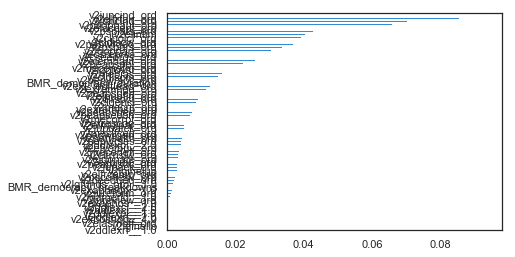

In [199]:
interpreter = Interpretation(cleaned_X, feature_names=indep_vars_list)
model = InMemoryModel(rf_fh.predict_proba, examples=cleaned_X, unique_values=[0, 1, 2])
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True, progressbar=False)
important_features = interpreter.feature_importance.feature_importance(model, ascending=False, progressbar=False)

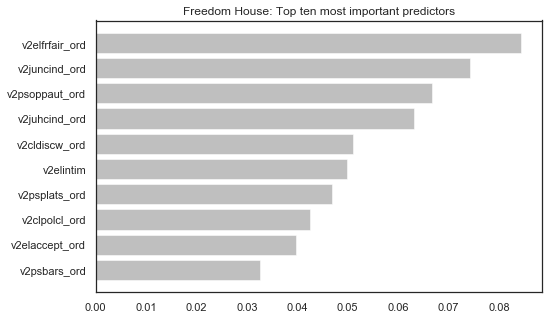

In [216]:
top_ten = important_features[:10]
plt.figure(figsize=(8, 5))
sorted_top_ten = top_ten.sort_values(ascending=True)
plt.barh(np.arange(10), sorted_top_ten.values, color='grey', alpha=0.5)
plt.yticks(np.arange(10), sorted_top_ten.index)
plt.title('Freedom House: Top ten most important predictors')
plt.savefig('fh_importance.png', bbox_inches='tight')

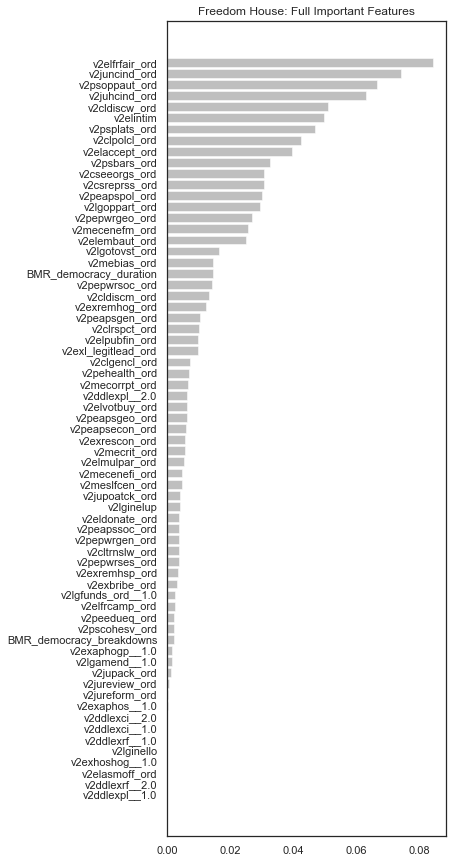

In [217]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.barh(np.arange(len(sorted_importance)), sorted_importance.values, color='grey', alpha=0.5)
plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
plt.title('Freedom House: Full Important Features')
plt.savefig('fh_full_importance.png', bbox_inches='tight')

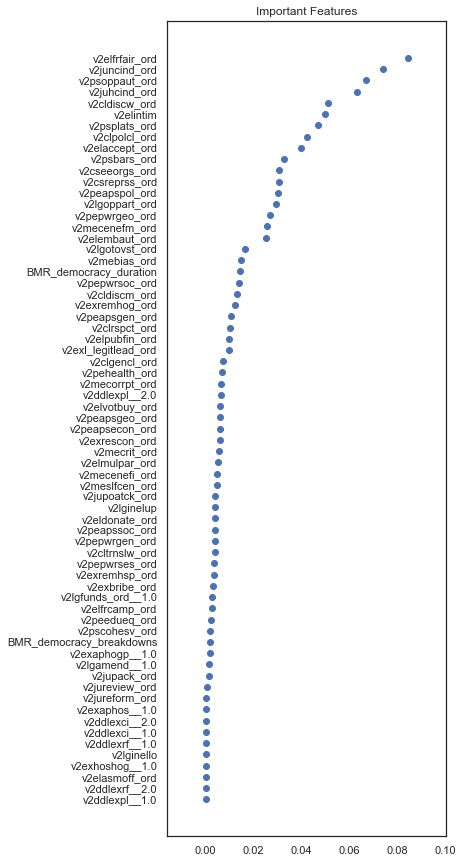

In [201]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.scatter(sorted_importance, np.arange(0,len(indep_vars_list)))
_ = plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
_ = plt.title('Important Features')

In [152]:
top_five = important_features[:5]
top_five

v2juhcind_ord     0.089690
v2elfrfair_ord    0.085487
v2psoppaut_ord    0.067202
v2elintim         0.059956
v2clpolcl_ord     0.053384
dtype: float64

### Predicting whether a country is experiencing/has experienced democratic erosion

#### Selecting dependent and independent variables
* dependent variable of interest = 'is_erosion' (Derived from Freedom House's 'Partly Free' status. If a country is classified by the Freedom House as partly free, that country-year experiences democratic erosion)
    * 0 = No erosion
    * 1 = Is experiencing or has experienced erosion
* independent variables = all others except for some variables lagged by one year

In [218]:
dependent_var = set(['country', 'year', 'is_erosion'])
dep_var = dem[dependent_var]

In [219]:
independent_vars = set(dem.columns) - dependent_var
independent_vars = list(independent_vars)
exclusion = ['PR', 'CL', 'BMR_democracy', 'FH_PF', 'FH_F', 'FH_NF',
             'Status','BMR_democracy_trans', 'FH_category']
no_shift = ['BMR_democracy_breakdowns', 'BMR_democracy_duration']
indep_vars_list = [x for x in independent_vars if x not in exclusion]
print(indep_vars_list)

['v2lginello', 'v2exbribe_ord', 'v2pepwrsoc_ord', 'v2exaphos__1.0', 'v2clgencl_ord', 'v2mecenefm_ord', 'v2eldonate_ord', 'v2mecorrpt_ord', 'v2peedueq_ord', 'BMR_democracy_duration', 'v2peapsgen_ord', 'v2juhcind_ord', 'v2csreprss_ord', 'v2ddlexpl__2.0', 'v2elvotbuy_ord', 'v2cldiscw_ord', 'v2mebias_ord', 'v2elembaut_ord', 'v2psplats_ord', 'v2ddlexci__1.0', 'v2jureview_ord', 'v2exremhog_ord', 'v2elpubfin_ord', 'v2psoppaut_ord', 'v2peapsgeo_ord', 'v2mecrit_ord', 'v2lgotovst_ord', 'v2elintim', 'v2elaccept_ord', 'v2elmulpar_ord', 'v2cltrnslw_ord', 'v2elasmoff_ord', 'v2ddlexci__2.0', 'v2elfrfair_ord', 'v2peapspol_ord', 'v2peapsecon_ord', 'v2exrescon_ord', 'v2lgamend__1.0', 'BMR_democracy_breakdowns', 'v2clrspct_ord', 'v2jureform_ord', 'v2pepwrgeo_ord', 'v2cldiscm_ord', 'v2psbars_ord', 'v2cseeorgs_ord', 'v2pepwrses_ord', 'v2clpolcl_ord', 'v2pepwrgen_ord', 'v2juncind_ord', 'v2pehealth_ord', 'v2exremhsp_ord', 'v2exl_legitlead_ord', 'v2pscohesv_ord', 'v2peapssoc_ord', 'v2mecenefi_ord', 'v2ddlexrf

In [220]:
id_indep_vars_list = ['country', 'year'] + indep_vars_list
indep_var = dem[id_indep_vars_list]

In [221]:
# lag every variable by 1 year
indep_var_shifted = indep_var.groupby(['country']).shift(periods=1)
indep_var_shifted.rename(columns={'year': 'prev_year'}, inplace=True)

In [222]:
final_df = pd.concat([dep_var, indep_var_shifted], axis=1)

In [223]:
final_df.drop(final_df[final_df['year'] == 2008].index, inplace=True)

In [224]:
# these are numpy arrays
X = final_df[indep_vars_list].values
y = final_df['is_erosion'].values

In [225]:
# dropna version
cleaned = final_df.dropna()
cleaned.drop(cleaned[cleaned['year'] == 2008].index, inplace=True)
cleaned.shape

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(94, 71)

In [226]:
cleaned_X = cleaned[indep_vars_list].values
cleaned_y = cleaned['is_erosion'].values

#### Model setup

In [164]:
max_dept = np.arange(2, 9)
fraction = np.arange(0.0, 0.5, 0.05)

In [165]:
rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],
                  'random_state': [1],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': max_dept,
                  'min_weight_fraction_leaf': fraction,
                  'n_jobs': [-1],
                  'bootstrap': [True, False]}

In [166]:
tic = time.time()
rf = RandomForestClassifier()
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5,
                             scoring='accuracy', n_jobs=-1,
                             iid=False, return_train_score=True)
rf_gs.fit(cleaned_X, cleaned_y)
toc = time.time()
print("Time elapsed: {:.3f} seconds".format(toc - tic))

Time elapsed: 1158.619 seconds


In [167]:
print('Best hyperparameter setting for Random Forests is {}'.format(rf_gs.best_params_))
print('5-fold accuracy score is {:.3f}'.format(rf_gs.best_score_))

Best hyperparameter setting for Random Forests is {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 1}
5-fold accuracy score is 0.927


In [168]:
best_rf = rf_gs.best_estimator_
best_rf.fit(cleaned_X, cleaned_y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [227]:
rf_erosion = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
rf_erosion.fit(cleaned_X, cleaned_y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [228]:
estimator = rf_erosion.estimators_[5]

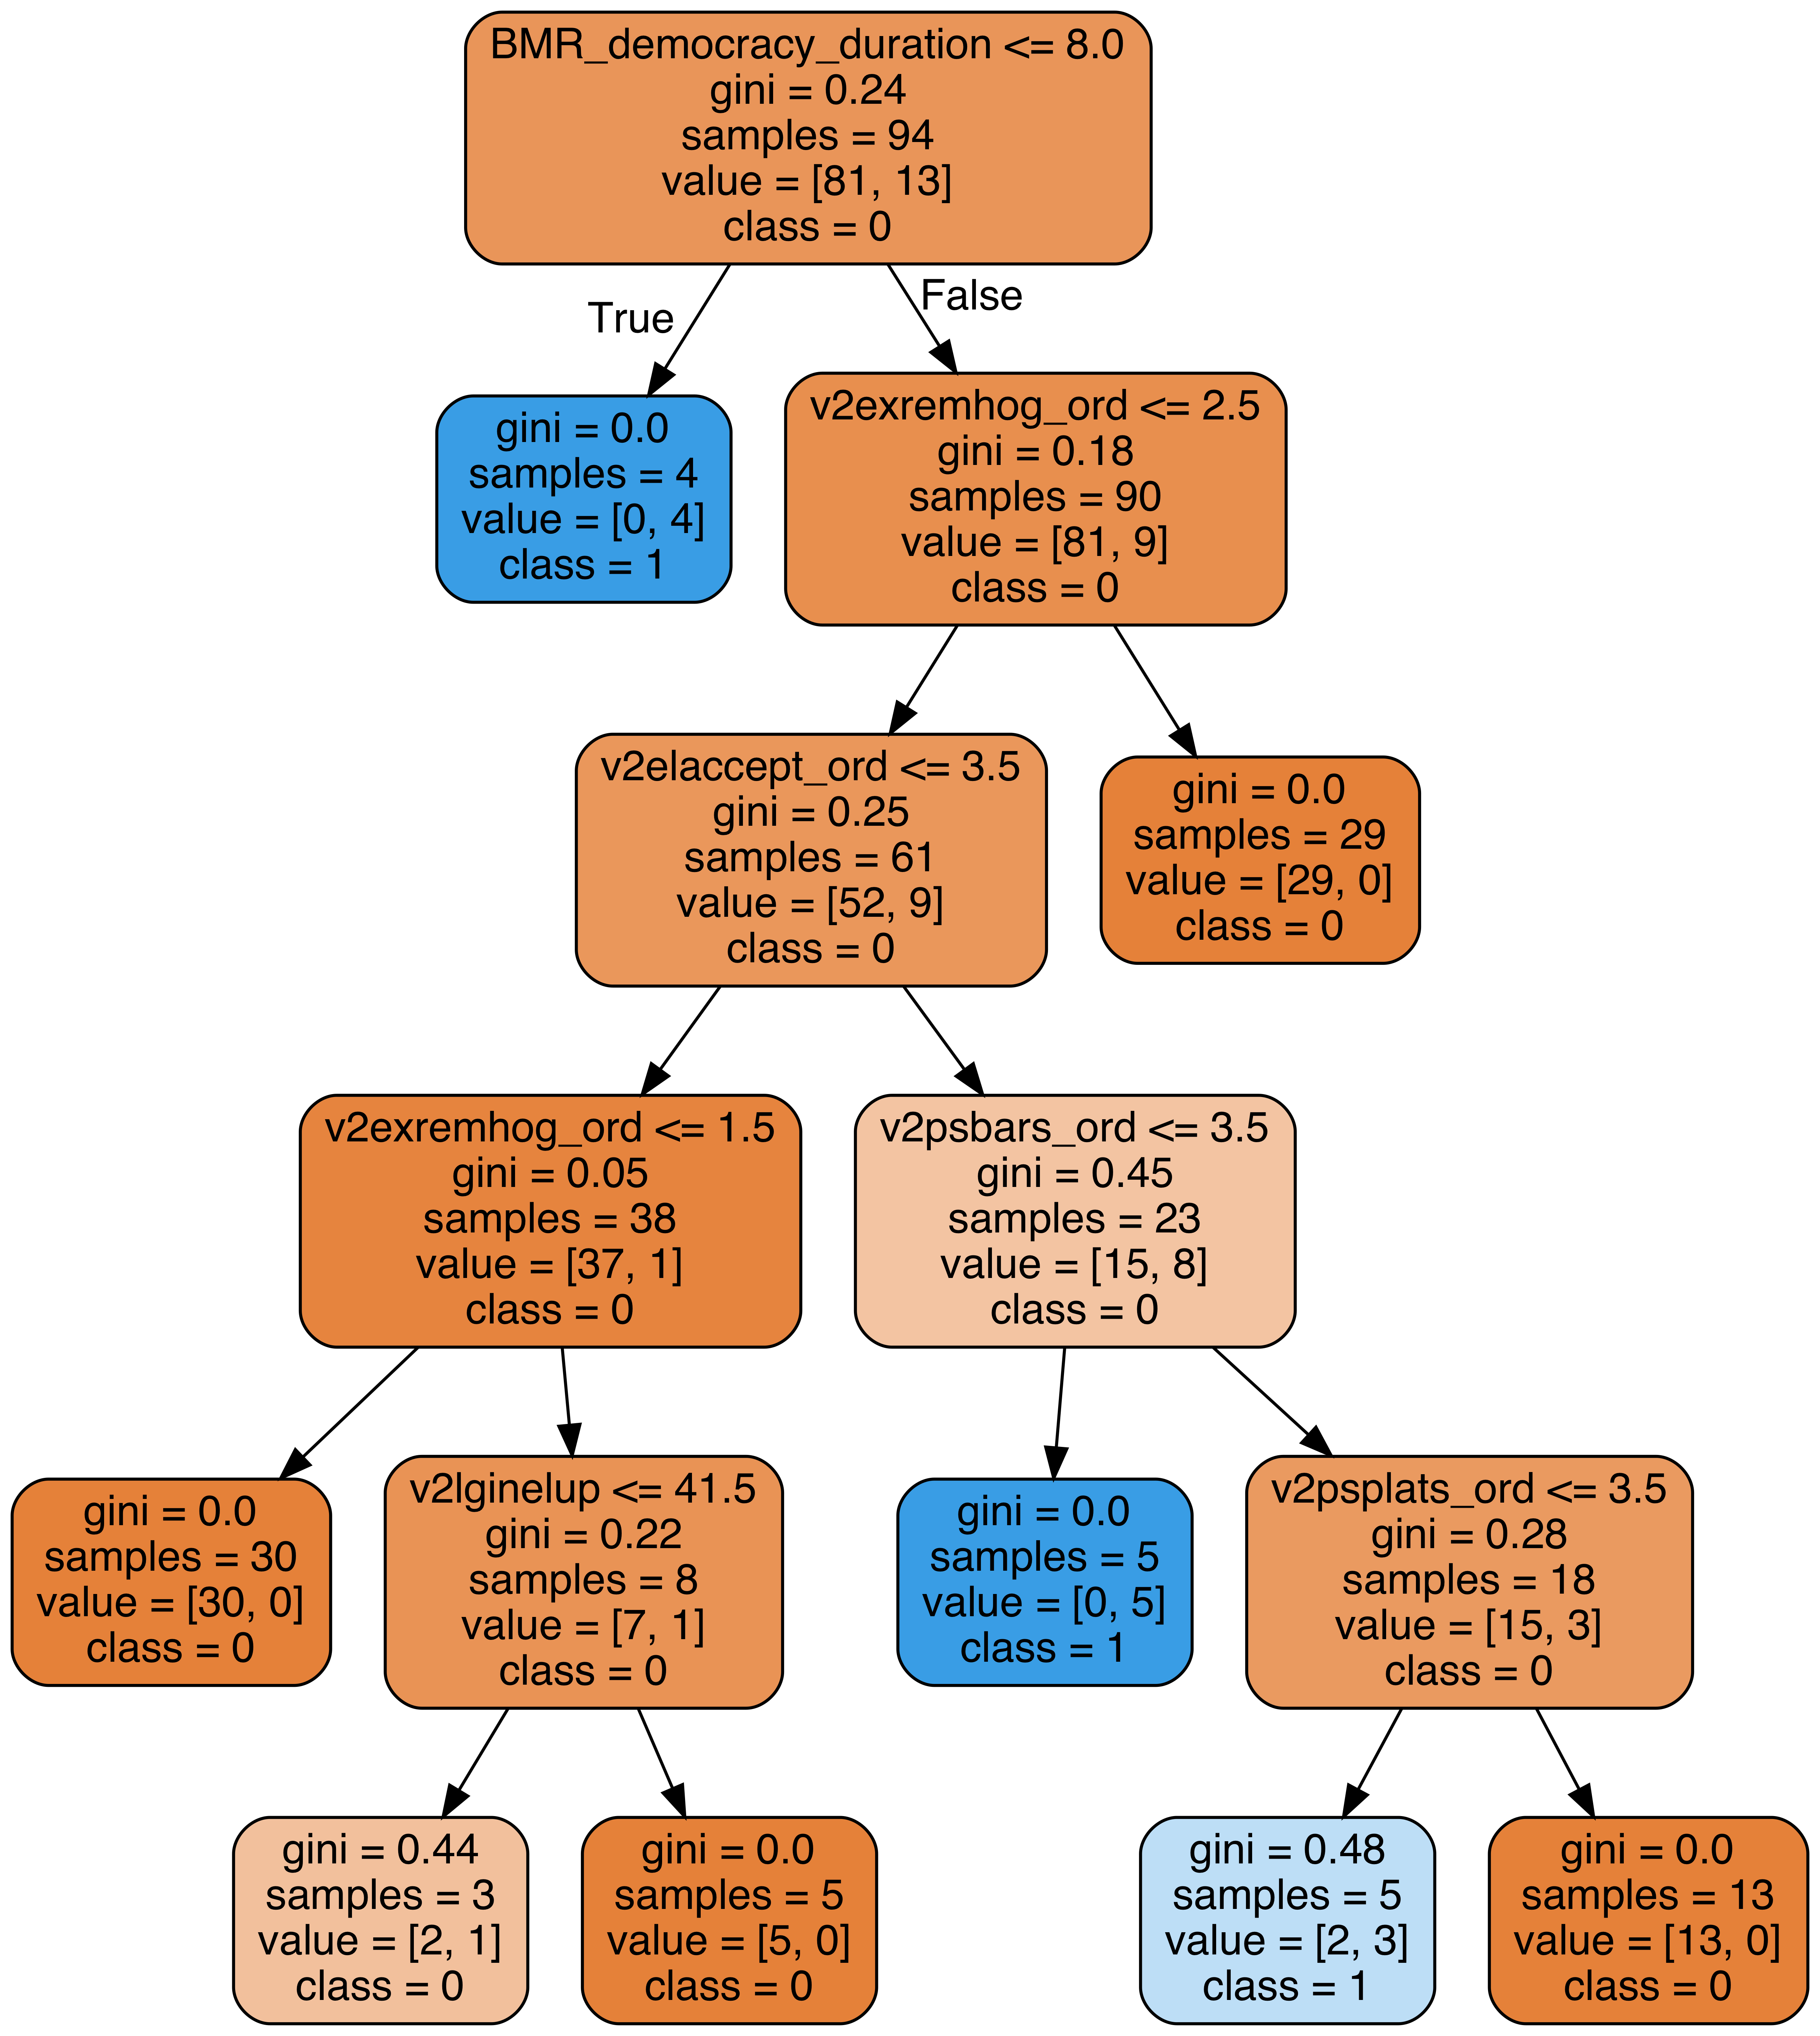

In [229]:
# code taken from https://towardsdatascience.com/how-to-visualize-a-decision-tree-
# from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
from sklearn.ensemble import RandomForestClassifier
# best_rf = rf_gs.best_estimator_

# Train
# best_rf.fit(cleaned_X, cleaned_y)
# Extract single tree
# estimator = best_rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=indep_vars_list,
                class_names=['0', '1', '2'],
                rounded=True, proportion=False, 
                precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

#### Inpterpreting the model

In [230]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [231]:
sns.set(style="white")
np.random.seed(1)

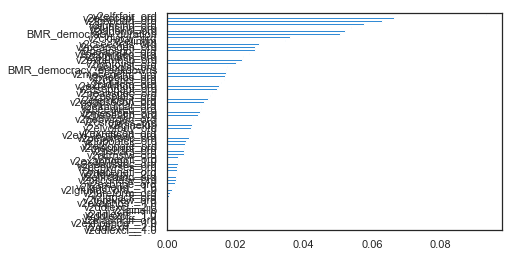

In [232]:
interpreter = Interpretation(cleaned_X, feature_names=indep_vars_list)
model = InMemoryModel(rf_erosion.predict_proba, examples=cleaned_X, unique_values=[0, 1])
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True, progressbar=False)
important_features = interpreter.feature_importance.feature_importance(model, ascending=False, progressbar=False)

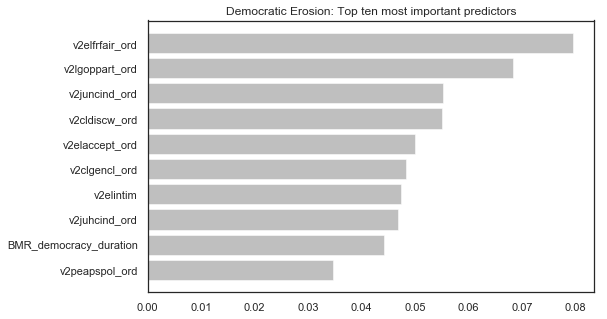

In [233]:
top_ten = important_features[:10]
plt.figure(figsize=(8, 5))
sorted_top_ten = top_ten.sort_values(ascending=True)
plt.barh(np.arange(10), sorted_top_ten.values, color='grey', alpha=0.5)
plt.yticks(np.arange(10), sorted_top_ten.index)
plt.title('Democratic Erosion: Top ten most important predictors')
plt.savefig('fh_importance_de.png', bbox_inches='tight')

([<matplotlib.axis.YTick at 0x1a205f8c18>,
 <a list of 10 Text yticklabel objects>)

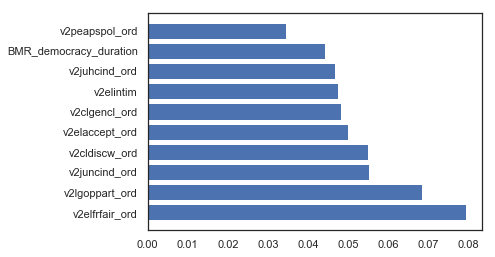

In [176]:
top_ten = important_features[:10]
plt.barh(np.arange(10), top_ten.values)
plt.yticks(np.arange(10), top_ten.index)

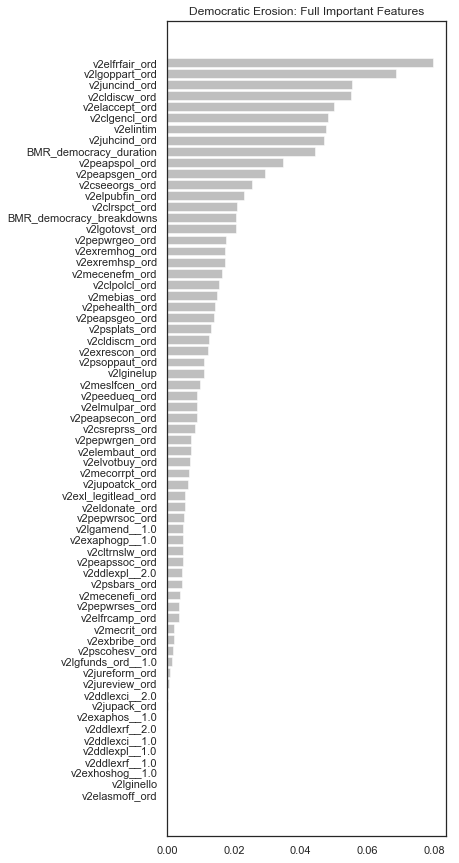

In [234]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.barh(np.arange(len(sorted_importance)), sorted_importance.values, color='grey', alpha=0.5)
plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
plt.title('Democratic Erosion: Full Important Features')
plt.savefig('de_full_importance.png', bbox_inches='tight')

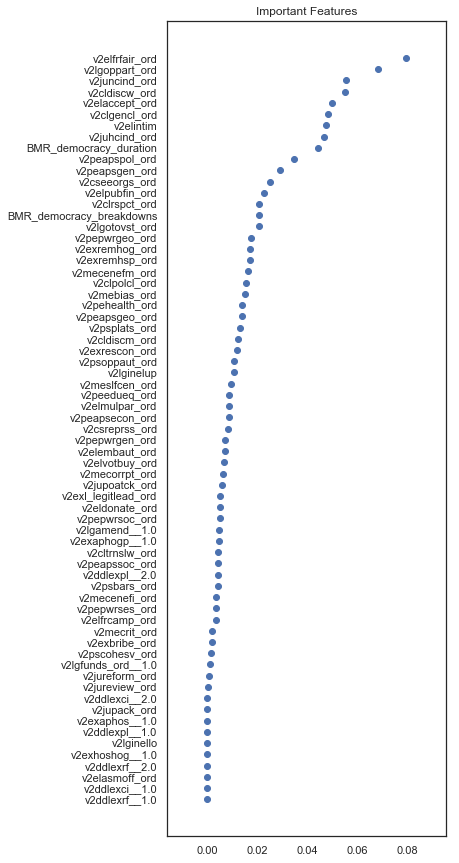

In [177]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.scatter(sorted_importance, np.arange(0,len(indep_vars_list)))
_ = plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
_ = plt.title('Important Features')

In [178]:
top_five = important_features[:5]
top_five

v2elfrfair_ord    0.079525
v2lgoppart_ord    0.068401
v2juncind_ord     0.055322
v2cldiscw_ord     0.055035
v2elaccept_ord    0.049955
dtype: float64